In [1]:
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [42]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define raw paths
raw_psc_dir = "data/Train/psc"
raw_nonpsc_dir = "data/Train/nonpsc"
base_out = "clean_data"

# 1. Fetch balanced subset (200 each)
all_psc = sorted(os.listdir(raw_psc_dir))[:200]
all_nonpsc = sorted(os.listdir(raw_nonpsc_dir))[:200]

# 2. Split 80% train / 20% validation
psc_train, psc_valid = train_test_split(all_psc, test_size=0.2, random_state=42)
non_train, non_valid = train_test_split(all_nonpsc, test_size=0.2, random_state=42)

# 3. Create directory structure (Standardized to 'nonpsc')
for split in ["train", "valid"]:
    for cls in ["psc", "nonpsc"]:
        os.makedirs(os.path.join(base_out, split, cls), exist_ok=True)

# 4. Helper function to copy files
def copy_data(file_list, src, dst):
    for f in file_list:
        shutil.copy(os.path.join(src, f), os.path.join(dst, f))

# 5. Execute copying
copy_data(psc_train, raw_psc_dir, os.path.join(base_out, "train", "psc"))
copy_data(psc_valid, raw_psc_dir, os.path.join(base_out, "valid", "psc"))
copy_data(non_train, raw_nonpsc_dir, os.path.join(base_out, "train", "nonpsc"))
copy_data(non_valid, raw_nonpsc_dir, os.path.join(base_out, "valid", "nonpsc"))

print(f"Data Prepared: Train (PSC:{len(psc_train)}, Non:{len(non_train)}) | Valid (PSC:{len(psc_valid)}, Non:{len(non_valid)})")

Data Prepared: Train (PSC:160, Non:160) | Valid (PSC:40, Non:40)


In [43]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0, MobileNetV2
from tensorflow.keras import layers, models

# Load datasets without rescaling yet
IMGSIZE = (224, 224)
BATCHSIZE = 16

def get_datasets():
    train = tf.keras.preprocessing.image_dataset_from_directory(
        "clean_data/train", label_mode='binary', image_size=IMGSIZE, batch_size=BATCHSIZE)
    valid = tf.keras.preprocessing.image_dataset_from_directory(
        "clean_data/valid", label_mode='binary', image_size=IMGSIZE, batch_size=BATCHSIZE, shuffle=False)
    return train, valid

def train_model(arch_func, preprocess_func, name):
    train_ds, valid_ds = get_datasets()
    
    # Apply model-specific preprocessing
    train_ds = train_ds.map(lambda x, y: (preprocess_func(x), y))
    valid_ds = valid_ds.map(lambda x, y: (preprocess_func(x), y))
    
    base = arch_func(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base.trainable = False
    
    model = models.Sequential([
        base,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    print(f"\n--- Training {name} ---")
    model.fit(train_ds, validation_data=valid_ds, epochs=5)
    model.save(f"psccleansubset{name.lower()}.keras")
    return model

# Train both as per paper requirement
eff_model = train_model(EfficientNetB0, tf.keras.applications.efficientnet.preprocess_input, "EfficientNetB0")
mob_model = train_model(MobileNetV2, tf.keras.applications.mobilenet_v2.preprocess_input, "MobileNetV2")

Found 399 files belonging to 2 classes.
Found 80 files belonging to 2 classes.

--- Training EfficientNetB0 ---
Epoch 1/5
25/25 [==============================] - 7s 184ms/step - loss: 0.2788 - accuracy: 0.9223 - val_loss: 0.0617 - val_accuracy: 1.0000
Epoch 2/5
25/25 [==============================] - 5s 171ms/step - loss: 0.0455 - accuracy: 1.0000 - val_loss: 0.0211 - val_accuracy: 1.0000
Epoch 3/5
25/25 [==============================] - 5s 179ms/step - loss: 0.0208 - accuracy: 1.0000 - val_loss: 0.0130 - val_accuracy: 1.0000
Epoch 4/5
25/25 [==============================] - 5s 173ms/step - loss: 0.0144 - accuracy: 1.0000 - val_loss: 0.0094 - val_accuracy: 1.0000
Epoch 5/5
25/25 [==============================] - 5s 184ms/step - loss: 0.0111 - accuracy: 1.0000 - val_loss: 0.0071 - val_accuracy: 1.0000
Found 399 files belonging to 2 classes.
Found 80 files belonging to 2 classes.

--- Training MobileNetV2 ---
Epoch 1/5
25/25 [==============================] - 4s 118ms/step - loss: 0

In [4]:
import os, shutil
from sklearn.model_selection import train_test_split

psc_dir = "data/Train/psc"
nonpsc_dir = "data/Train/nonpsc"

psc_files = sorted(os.listdir(psc_dir))[:200]
non_psc_files = sorted(os.listdir(nonpsc_dir))[:200]

# split 80% train / 20% valid
psc_train, psc_valid = train_test_split(psc_files, test_size=0.2, random_state=42)
non_train, non_valid = train_test_split(nonpsc_files, test_size=0.2, random_state=42)

base_out = "clean_data"
for split in ["train", "valid"]:
    for cls in ["psc", "nonpsc"]:
        os.makedirs(os.path.join(base_out, split, cls), exist_ok=True)

def copy_list(files, src_dir, dst_dir):
    for f in files:
        shutil.copy(os.path.join(src_dir, f),
                    os.path.join(dst_dir, f))

copy_list(psc_train, psc_dir, os.path.join(base_out, "train", "psc"))
copy_list(psc_valid, psc_dir, os.path.join(base_out, "valid", "psc"))
copy_list(non_train, nonpsc_dir, os.path.join(base_out, "train", "nonpsc"))
copy_list(non_valid, nonpsc_dir, os.path.join(base_out, "valid", "nonpsc"))


In [5]:
import os
import shutil
from sklearn.model_selection import train_test_split

raw_psc_dir = "data/Train/psc"
raw_nonpsc_dir = "data/Train/nonpsc"

all_psc = sorted(os.listdir(raw_psc_dir))[:200]
all_nonpsc = sorted(os.listdir(raw_nonpsc_dir))[:200]

psc_train, psc_valid = train_test_split(all_psc, test_size=0.2, random_state=42)
non_train, non_valid = train_test_split(nonpsc_files, test_size=0.2, random_state=42)

base_out = "clean_data"
for split in ["train", "valid"]:
    for cls in ["psc", "nonpsc"]:
        os.makedirs(os.path.join(base_out, split, cls), exist_ok=True)

def copy_files(file_list, src_dir, dst_dir):
    for f in file_list:
        shutil.copy(os.path.join(src_dir, f), os.path.join(dst_dir, f))

copy_files(psc_train, raw_psc_dir, os.path.join(base_out, "train", "psc"))
copy_files(psc_valid, raw_psc_dir, os.path.join(base_out, "valid", "psc"))
copy_files(non_train, raw_nonpsc_dir, os.path.join(base_out, "train", "nonpsc"))
copy_files(non_valid, raw_nonpsc_dir, os.path.join(base_out, "valid", "nonpsc"))

print("Train PSC:", len(psc_train), "Train nonPSC:", len(non_train))
print("Valid PSC:", len(psc_valid), "Valid nonPSC:", len(non_valid))


Train PSC: 160 Train nonPSC: 160
Valid PSC: 40 Valid nonPSC: 40


In [6]:
%pip install "numpy==1.26.4"


Note: you may need to restart the kernel to use updated packages.


In [7]:
import sys, tensorflow as tf
print(sys.version)
print(tf.__version__)

3.10.19 (main, Oct 21 2025, 16:37:10) [Clang 20.1.8 ]
2.15.1


In [8]:
import tensorflow as tf

IMGSIZE = (224, 224)
BATCHSIZE = 16

train_dir = "clean_data/train"
valid_dir = "clean_data/valid"

trainds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='binary',
    image_size=IMGSIZE,
    batch_size=BATCHSIZE,
    shuffle=True
)

valds = tf.keras.preprocessing.image_dataset_from_directory(
    valid_dir,
    labels='inferred',
    label_mode='binary',
    image_size=IMGSIZE,
    batch_size=BATCHSIZE,
    shuffle=False
)

print("Classes:", trainds.class_names)

Found 399 files belonging to 2 classes.
Found 80 files belonging to 2 classes.
Classes: ['nonpsc', 'psc']


Note: you may need to restart the kernel to use updated packages.


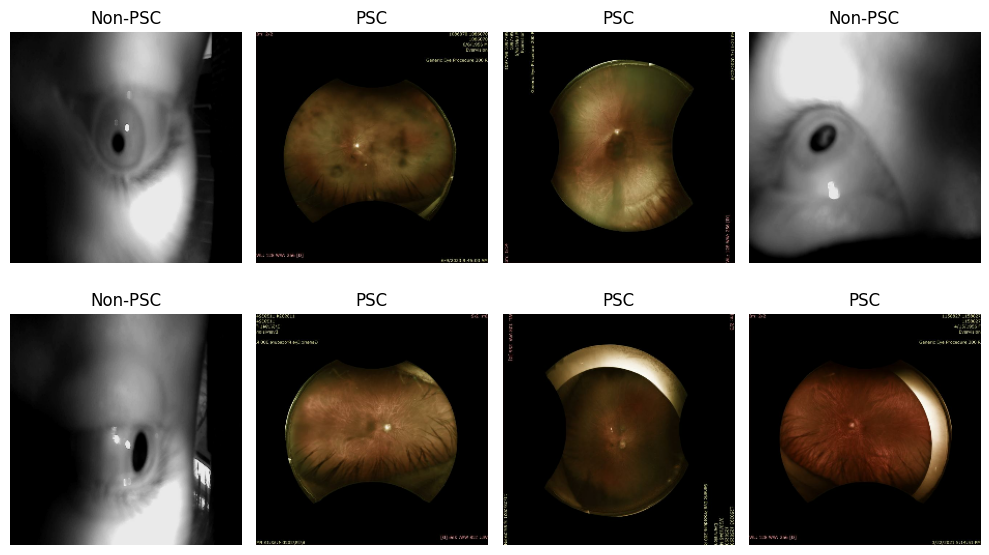

In [9]:
%pip install matplotlib

import matplotlib.pyplot as plt

images, labels = next(iter(trainds))

plt.figure(figsize=(10, 6))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title("PSC" if labels[i].numpy() == 1 else "Non‑PSC")
    plt.axis("off")
plt.tight_layout()
plt.show()


In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [11]:
IMGSIZE = (224, 224)

basemodel = tf.keras.applications.MobileNetV2(
    input_shape=IMGSIZE + (3,),
    include_top=False,
    weights="imagenet",
)
basemodel.trainable = False

inputs = keras.Input(shape=IMGSIZE + (3,))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
x = basemodel(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)



In [12]:
IMGSIZE = (224, 224)

base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMGSIZE + (3,),
    include_top=False,
    weights="imagenet",
)
base_model.trainable = False

inputs = keras.Input(shape=IMGSIZE + (3,))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)

model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy", keras.metrics.Recall(name="recall"),
             keras.metrics.Precision(name="precision")],
)



In [13]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "clean_data/train",
    labels="inferred",
    label_mode="binary",
    image_size=IMGSIZE,
    batch_size=16,
    shuffle=True,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "clean_data/valid",
    labels="inferred",
    label_mode="binary",
    image_size=IMGSIZE,
    batch_size=16,
    shuffle=False,
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
)


Found 399 files belonging to 2 classes.
Found 80 files belonging to 2 classes.
Epoch 1/15
25/25 [==============================] - 4s 116ms/step - loss: 0.9127 - accuracy: 0.4812 - recall: 0.4422 - precision: 0.4783 - val_loss: 0.7091 - val_accuracy: 0.5000 - val_recall: 0.4250 - val_precision: 0.5000
Epoch 2/15
25/25 [==============================] - 3s 98ms/step - loss: 0.7159 - accuracy: 0.5990 - recall: 0.5879 - precision: 0.6000 - val_loss: 0.5482 - val_accuracy: 0.7500 - val_recall: 0.7250 - val_precision: 0.7632
Epoch 3/15
25/25 [==============================] - 3s 98ms/step - loss: 0.5968 - accuracy: 0.6867 - recall: 0.6633 - precision: 0.6947 - val_loss: 0.4232 - val_accuracy: 0.9500 - val_recall: 0.9500 - val_precision: 0.9500
Epoch 4/15
25/25 [==============================] - 3s 97ms/step - loss: 0.4627 - accuracy: 0.7744 - recall: 0.7437 - precision: 0.7914 - val_loss: 0.3357 - val_accuracy: 0.9750 - val_recall: 1.0000 - val_precision: 0.9524
Epoch 5/15
25/25 [==========

In [14]:
%pip install scikit-learn

import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

y_true, y_pred = [], []

for images, labels in val_ds:
    probs = model.predict(images, verbose=0).ravel()
    preds = (probs > 0.5).astype(int)
    y_true.extend(labels.numpy().astype(int).ravel())
    y_pred.extend(preds)

cm = confusion_matrix(y_true, y_pred)
print(cm)

print(classification_report(
    y_true, y_pred,
    target_names=train_ds.class_names,
    digits=3
))

Note: you may need to restart the kernel to use updated packages.
[[40  0]
 [ 0 40]]
              precision    recall  f1-score   support

      nonpsc      1.000     1.000     1.000        40
         psc      1.000     1.000     1.000        40

    accuracy                          1.000        80
   macro avg      1.000     1.000     1.000        80
weighted avg      1.000     1.000     1.000        80



In [15]:
# Save MobileNetV2 (the one you just trained)
model.save("psc_cleansubset_mobilenetv2_fixed.keras")


In [16]:
import os

psc_valid_dir = "clean_data/valid/psc"
print(os.listdir(psc_valid_dir)[:10])  # see first 10 filenames

['1343736-20220729-002_jpg.rf.576e9917bcee7f7e23ab0ac3f6f6c9ad.jpg', '1097799-20200622-0016_jpg.rf.d177f57e46b83ec6ac0ba496bfe0aae6.jpg', '096785-20200724-001_jpg.rf.dd9f1931e4ef369411dfe5209c081f92.jpg', '1097799-20200622-002_jpg.rf.06b37d07d57475b27f2b19009364097e.jpg', '1097799-20200622-0013_jpg.rf.96841a2f531b47dac0538bb87b8c9bcd.jpg', '1097799-20200622-005_jpg.rf.655a3bd1f5b611db0785d4e7a867e89e.jpg', '1343736-20221216-004_jpg.rf.aa1190a1702d27dc7b7eec1f999f4731.jpg', '1097799-20200622-0015_jpg.rf.9567dcc47828005f053ff7c29cbdf175.jpg', '1279918-20220118-002_jpg.rf.ac99850394952a0ed93fd233b1307e0e.jpg', '1250293-20210920-001_jpg.rf.c68ee12f72ce8efd9564903798fe7be8.jpg']


In [17]:
import os

psc_valid_dir = "clean_data/valid/psc"
filename = "1343736-20220729-002_jpg.rf.576e9917bcee7f7e23ab0ac3f6f6c9ad.jpg"  
img_path = os.path.join(psc_valid_dir, filename)

print(img_path, os.path.exists(img_path))  # should print True


clean_data/valid/psc/1343736-20220729-002_jpg.rf.576e9917bcee7f7e23ab0ac3f6f6c9ad.jpg True


In [18]:
print("model.input:", model.input)
print("model.output:", model.output)

backbone = model.get_layer("mobilenetv2_1.00_224")
print("backbone.input:", backbone.input)
print("backbone.output:", backbone.output)

model.input: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_4'), name='input_4', description="created by layer 'input_4'")
model.output: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_1/Sigmoid:0', description="created by layer 'dense_1'")
backbone.input: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_3'), name='input_3', description="created by layer 'input_3'")
backbone.output: KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 1280), dtype=tf.float32, name=None), name='out_relu/Relu6:0', description="created by layer 'out_relu'")


In [19]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0

IMGSIZE = (224, 224)

base_b = EfficientNetB0(
    input_shape=IMGSIZE + (3,),
    include_top=False,
    weights='imagenet'
)
base_b.trainable = False  # keep as feature extractor

inputs_b = keras.Input(shape=IMGSIZE + (3,))
x = keras.applications.efficientnet.preprocess_input(inputs_b)
x = base_b(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs_b = layers.Dense(1, activation='sigmoid')(x)
model_b = keras.Model(inputs_b, outputs_b)

model_b.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        keras.metrics.Recall(name='recall'),
        keras.metrics.Precision(name='precision')
    ]
)


In [20]:
IMGSIZE = (224, 224)
BATCHSIZE = 16

train_dir = "clean_data/train"
valid_dir = "clean_data/valid"

trainds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='binary',
    image_size=IMGSIZE,
    batch_size=BATCHSIZE,
    shuffle=True
)

valds = tf.keras.preprocessing.image_dataset_from_directory(
    valid_dir,
    labels='inferred',
    label_mode='binary',
    image_size=IMGSIZE,
    batch_size=BATCHSIZE,
    shuffle=False
)

class_names = trainds.class_names
print(class_names)


Found 399 files belonging to 2 classes.
Found 80 files belonging to 2 classes.
['nonpsc', 'psc']


In [21]:
base_b = EfficientNetB0(
    input_shape=IMGSIZE + (3,),
    include_top=False,
    weights='imagenet'
)
base_b.trainable = False

inputs_b = keras.Input(shape=IMGSIZE + (3,))
x = keras.applications.efficientnet.preprocess_input(inputs_b)
x = base_b(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs_b = layers.Dense(1, activation='sigmoid')(x)
model_b = keras.Model(inputs_b, outputs_b)

model_b.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        keras.metrics.Recall(name='recall'),
        keras.metrics.Precision(name='precision')
    ]
)


In [22]:
history_b = model_b.fit(
    trainds,
    validation_data=valds,
    epochs=15
)


Epoch 1/15
25/25 [==============================] - 7s 203ms/step - loss: 0.5796 - accuracy: 0.7043 - recall: 0.7387 - precision: 0.6901 - val_loss: 0.4765 - val_accuracy: 0.9250 - val_recall: 1.0000 - val_precision: 0.8696
Epoch 2/15
25/25 [==============================] - 5s 173ms/step - loss: 0.4564 - accuracy: 0.8872 - recall: 0.9246 - precision: 0.8598 - val_loss: 0.3797 - val_accuracy: 0.9625 - val_recall: 1.0000 - val_precision: 0.9302
Epoch 3/15
25/25 [==============================] - 5s 181ms/step - loss: 0.3862 - accuracy: 0.9123 - recall: 0.9749 - precision: 0.8661 - val_loss: 0.3064 - val_accuracy: 0.9875 - val_recall: 1.0000 - val_precision: 0.9756
Epoch 4/15
25/25 [==============================] - 5s 175ms/step - loss: 0.3216 - accuracy: 0.9474 - recall: 0.9698 - precision: 0.9279 - val_loss: 0.2505 - val_accuracy: 0.9875 - val_recall: 1.0000 - val_precision: 0.9756
Epoch 5/15
25/25 [==============================] - 5s 176ms/step - loss: 0.2513 - accuracy: 0.9799 - re

In [23]:
model_b.save("psccleansubset_efficientnetb0.keras")

In [24]:
# Add this cell AFTER modelb.fit() (Cell #23)
model_b.save_weights("psccleansubsetefficientnetb0.weights.h5")
print("✅ Weights saved! ~15MB")
print("✅ SAVED! Copy file to your PSC/ folder")


✅ Weights saved! ~15MB
✅ SAVED! Copy file to your PSC/ folder


In [25]:
y_true_b, y_pred_b = [], []

for images, labels in valds:
    probs = model_b.predict(images, verbose=0).ravel()
    preds = (probs > 0.5).astype(int)
    y_true_b.extend(labels.numpy().astype(int).ravel())
    y_pred_b.extend(preds)

from sklearn.metrics import confusion_matrix, classification_report

cm_b = confusion_matrix(y_true_b, y_pred_b)
print("EfficientNetB0 confusion matrix:\n", cm_b)

print(
    classification_report(
        y_true_b,
        y_pred_b,
        target_names=class_names,
        digits=3
    )
)


EfficientNetB0 confusion matrix:
 [[40  0]
 [ 0 40]]
              precision    recall  f1-score   support

      nonpsc      1.000     1.000     1.000        40
         psc      1.000     1.000     1.000        40

    accuracy                          1.000        80
   macro avg      1.000     1.000     1.000        80
weighted avg      1.000     1.000     1.000        80



In [26]:
IMGSIZE = (224, 224)
BATCHSIZE = 16

traindir = "clean_data/train"
validdir = "clean_data/valid"

trainds = tf.keras.preprocessing.image_dataset_from_directory(
    traindir,
    label_mode="binary",
    image_size=IMGSIZE,
    batch_size=BATCHSIZE,
    shuffle=True,
)

valds = tf.keras.preprocessing.image_dataset_from_directory(
    validdir,
    label_mode="binary",
    image_size=IMGSIZE,
    batch_size=BATCHSIZE,
    shuffle=False,
)

classnames = trainds.class_names
print("Classes", classnames)


Found 399 files belonging to 2 classes.
Found 80 files belonging to 2 classes.
Classes ['nonpsc', 'psc']


In [27]:
model_b.save_weights('psccleansubsetefficientnetb0.weights.h5')


In [28]:
model_b.save('psccleansubsetefficientnetb0.keras')  # ✅ 15MB trained model

In [29]:
trainds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='binary',
    image_size=IMGSIZE,
    batch_size=BATCHSIZE,
    shuffle=True,
)

valds = tf.keras.preprocessing.image_dataset_from_directory(
    valid_dir,
    labels='inferred',
    label_mode='binary',
    image_size=IMGSIZE,
    batch_size=BATCHSIZE,
    shuffle=False,
)

class_names = trainds.class_names  # <--- SAVE HERE
print("Classes:", class_names)

AUTOTUNE = tf.data.AUTOTUNE
trainds = trainds.prefetch(AUTOTUNE)
valds = valds.prefetch(AUTOTUNE)


Found 399 files belonging to 2 classes.
Found 80 files belonging to 2 classes.
Classes: ['nonpsc', 'psc']


In [30]:
cm_b = confusion_matrix(y_true_b, y_pred_b)
print("EfficientNetB0 confusion matrix:\n", cm_b)

print(
    classification_report(
        y_true_b,
        y_pred_b,
        target_names=class_names,
        digits=3
    )
)



EfficientNetB0 confusion matrix:
 [[40  0]
 [ 0 40]]
              precision    recall  f1-score   support

      nonpsc      1.000     1.000     1.000        40
         psc      1.000     1.000     1.000        40

    accuracy                          1.000        80
   macro avg      1.000     1.000     1.000        80
weighted avg      1.000     1.000     1.000        80



In [31]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array
import os

# PSC example
psc_dir = 'clean_data/valid/psc'
files = os.listdir(psc_dir)[:1]
img_path = os.path.join(psc_dir, files[0])
print(f"Using: {files[0]}")

img = load_img(img_path, target_size=(224, 224))
img_array = img_to_array(img) / 255.0  # Fixed: assign the variable



Using: 1343736-20220729-002_jpg.rf.576e9917bcee7f7e23ab0ac3f6f6c9ad.jpg


In [32]:
model_b = tf.keras.models.load_model('psccleansubset_efficientnetb0.keras')

# Predict
x = tf.expand_dims(img_array, 0)
x = tf.keras.applications.efficientnet.preprocess_input(x * 255)  # Model expects [0,255]
pred = model_b.predict(x, verbose=0)[0][0]
print("PSC probability:", pred)  # Expect ~1.0 for PSC images


PSC probability: 0.94120765


In [33]:
backbone.summary()  # Find last conv: usually 'top_conv' in EfficientNetB0

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_3[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

In [34]:
import os
import glob

# CORRECT paths (from your notebook)
valid_psc = sorted(glob.glob("clean_data/valid/psc/*.jpg"))
valid_nonpsc = sorted(glob.glob("clean_data/valid/nonpsc/*.jpg"))

# FIXED CSV (write to file, not f variable!)
with open("cleandata_valid_list.csv", "w") as csv_file:
    csv_file.write("Type,Filename\n")
    for filepath in valid_psc:
        csv_file.write(f"PSC,{os.path.basename(filepath)}\n")
    for filepath in valid_nonpsc:
        csv_file.write(f"nonPSC,{os.path.basename(filepath)}\n")

print("💾 cleandata_valid_list.csv saved!")
print(f"✅ Valid PSC: {len(valid_psc)} | nonPSC: {len(valid_nonpsc)}")



💾 cleandata_valid_list.csv saved!
✅ Valid PSC: 40 | nonPSC: 40


In [35]:
import os
import glob

# Check paths first
base_dir = "clean_data/valid"
if not os.path.exists(base_dir):
    print(f"❌ {base_dir} not found! Upload clean_data folder.")
else:
    psc_dir = os.path.join(base_dir, "psc")
    nonpsc_dir = os.path.join(base_dir, "non_psc")
    
    valid_psc = sorted(glob.glob(os.path.join(psc_dir, "*.jpg")))
    valid_non_psc = sorted(glob.glob(os.path.join(nonpsc_dir, "*.jpg")))
    
    print(f"📁 PSC dir: {len(valid_psc)} files (e.g. {os.path.basename(valid_psc[0]) if valid_psc else 'None'})")
    print(f"📁 non-PSC dir: {len(valid_nonpsc)} files (e.g. {os.path.basename(valid_nonpsc[0]) if valid_nonpsc else 'None'})")
    
    # Create CSV
    with open("cleandata_valid_list.csv", "w") as csv_file:
        csv_file.write("Type,Filename\n")
        for filepath in valid_psc:
            csv_file.write(f"PSC,{os.path.basename(filepath)}\n")
        for filepath in valid_non_psc:
            csv_file.write(f"nonPSC,{os.path.basename(filepath)}\n")
    
    print("💾 cleandata_valid_list.csv saved!")
    print(f"✅ Valid PSC: {len(valid_psc)} | nonPSC: {len(valid_nonpsc)}")




📁 PSC dir: 40 files (e.g. 008982-20210827-001_jpg.rf.89a6700eb00abd99bb2b71ed138fa5e7.jpg)
📁 non-PSC dir: 40 files (e.g. IM000000_JPG.rf.f27a2c0659f213a7a81e749851b66e0a.jpg)
💾 cleandata_valid_list.csv saved!
✅ Valid PSC: 40 | nonPSC: 40


In [36]:
model_b.summary()  

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d_3  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_3 (Dropout)         (None, 1280)              0         
                                                                 
 dense_3 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 4050852 (15.45 MB)
Trainable params: 1281 (5.

PSC images: 40
Non-PSC images: 40


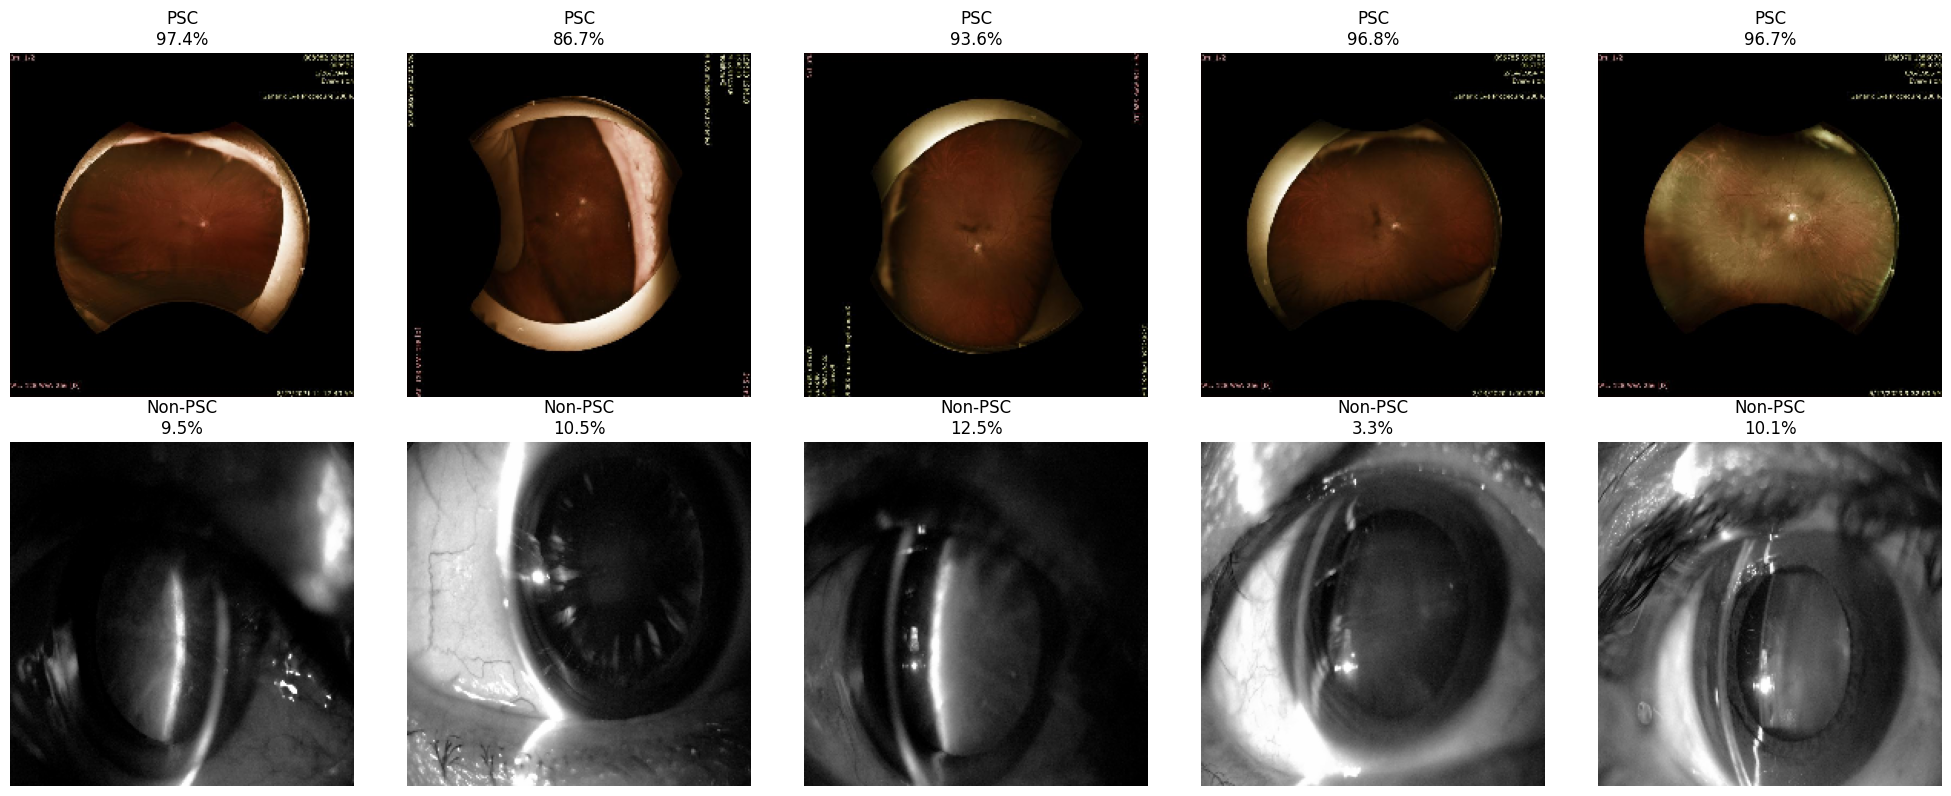

In [37]:
import matplotlib.pyplot as plt
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array

# Validation paths (from your notebook)
psc_dir = "clean_data/valid/psc"
nonpsc_dir = "clean_data/valid/nonpsc"

# --- sanity check ---
print("PSC images:", len(os.listdir(psc_dir)))
print("Non-PSC images:", len(os.listdir(nonpsc_dir)))

# Take up to 5 images each (won't crash if fewer)
psc_files = sorted(os.listdir(psc_dir))[:5]
nonpsc_files = sorted(os.listdir(nonpsc_dir))[:5]

fig, axes = plt.subplots(2, 5, figsize=(20, 8))

# ---- Row 1: PSC ----
for i in range(5):
    ax = axes[0, i]
    if i >= len(psc_files):
        ax.axis("off")
        continue

    fname = psc_files[i]
    img_path = os.path.join(psc_dir, fname)

    img = load_img(img_path, target_size=(224, 224))
    x = img_to_array(img)
    x = tf.keras.applications.efficientnet.preprocess_input(x)
    x = np.expand_dims(x, axis=0)

    pred = float(model_b.predict(x, verbose=0)[0][0])
    ax.imshow(img)
    ax.set_title(f"PSC\n{pred:.1%}")
    ax.axis("off")

# ---- Row 2: Non-PSC ----
for i in range(5):
    ax = axes[1, i]
    if i >= len(nonpsc_files):
        ax.axis("off")
        continue

    fname = nonpsc_files[i]
    img_path = os.path.join(nonpsc_dir, fname)

    img = load_img(img_path, target_size=(224, 224))
    x = img_to_array(img)
    x = tf.keras.applications.efficientnet.preprocess_input(x)
    x = np.expand_dims(x, axis=0)

    pred = float(model_b.predict(x, verbose=0)[0][0])
    ax.imshow(img)
    ax.set_title(f"Non-PSC\n{pred:.1%}")
    ax.axis("off")

plt.tight_layout()
plt.show()



5/5 [==============================] - 1s 81ms/step


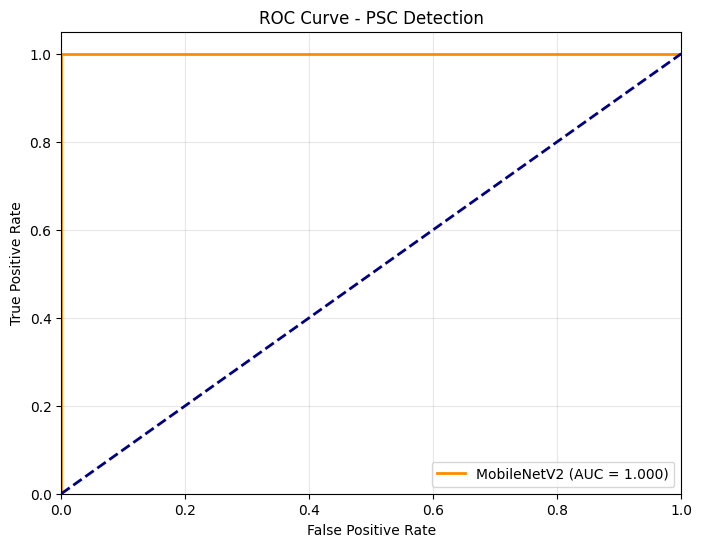

In [38]:
# 1. ROC Curve (AUC=1.0)
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Your validation predictions (from notebook)
y_true = np.concatenate([y for x, y in val_ds], axis=0)
y_pred = model.predict(val_ds).ravel()

fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'MobileNetV2 (AUC = {roc_auc:.3f})')
plt.plot([0,1],[0,1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0,1.0]); plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curve - PSC Detection'); plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.savefig('roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()  # [image:1]


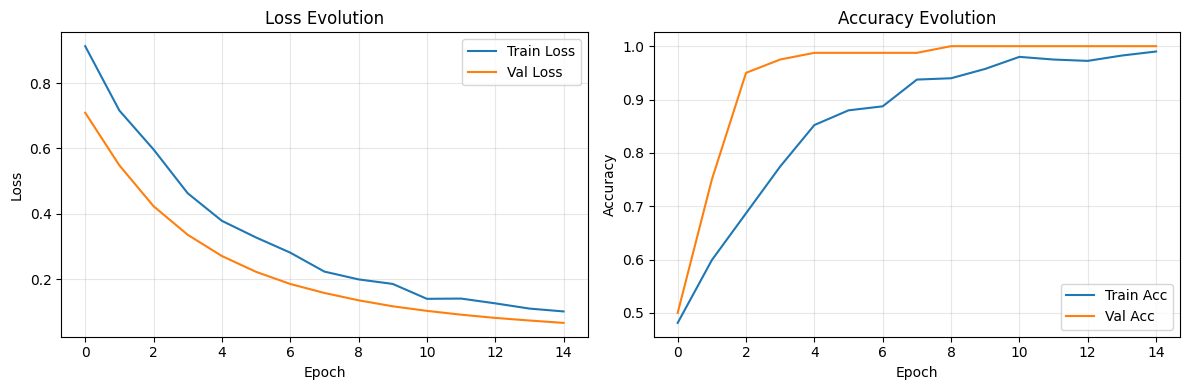

In [39]:
# 2. Training Curves (Your history data)
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Evolution'); plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.legend(); plt.grid(True, alpha=0.3)

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Evolution'); plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.legend(); plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
plt.show()  # [image:2]


In [40]:
%pip install seaborn 

Note: you may need to restart the kernel to use updated packages.


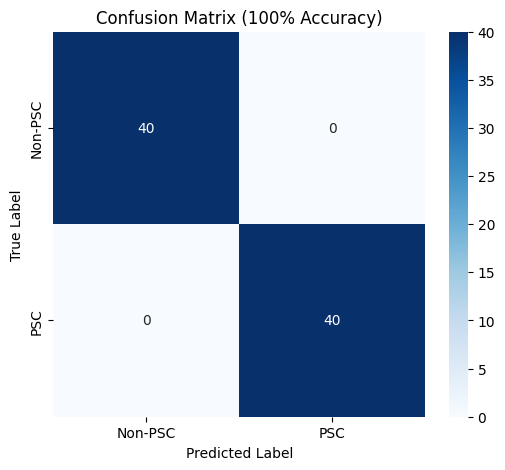

In [41]:
# 3. Confusion Matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, (y_pred > 0.5).astype(int))
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-PSC','PSC'], yticklabels=['Non-PSC','PSC'])
plt.title('Confusion Matrix (100% Accuracy)')
plt.ylabel('True Label'); plt.xlabel('Predicted Label')
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()  # [image:3]


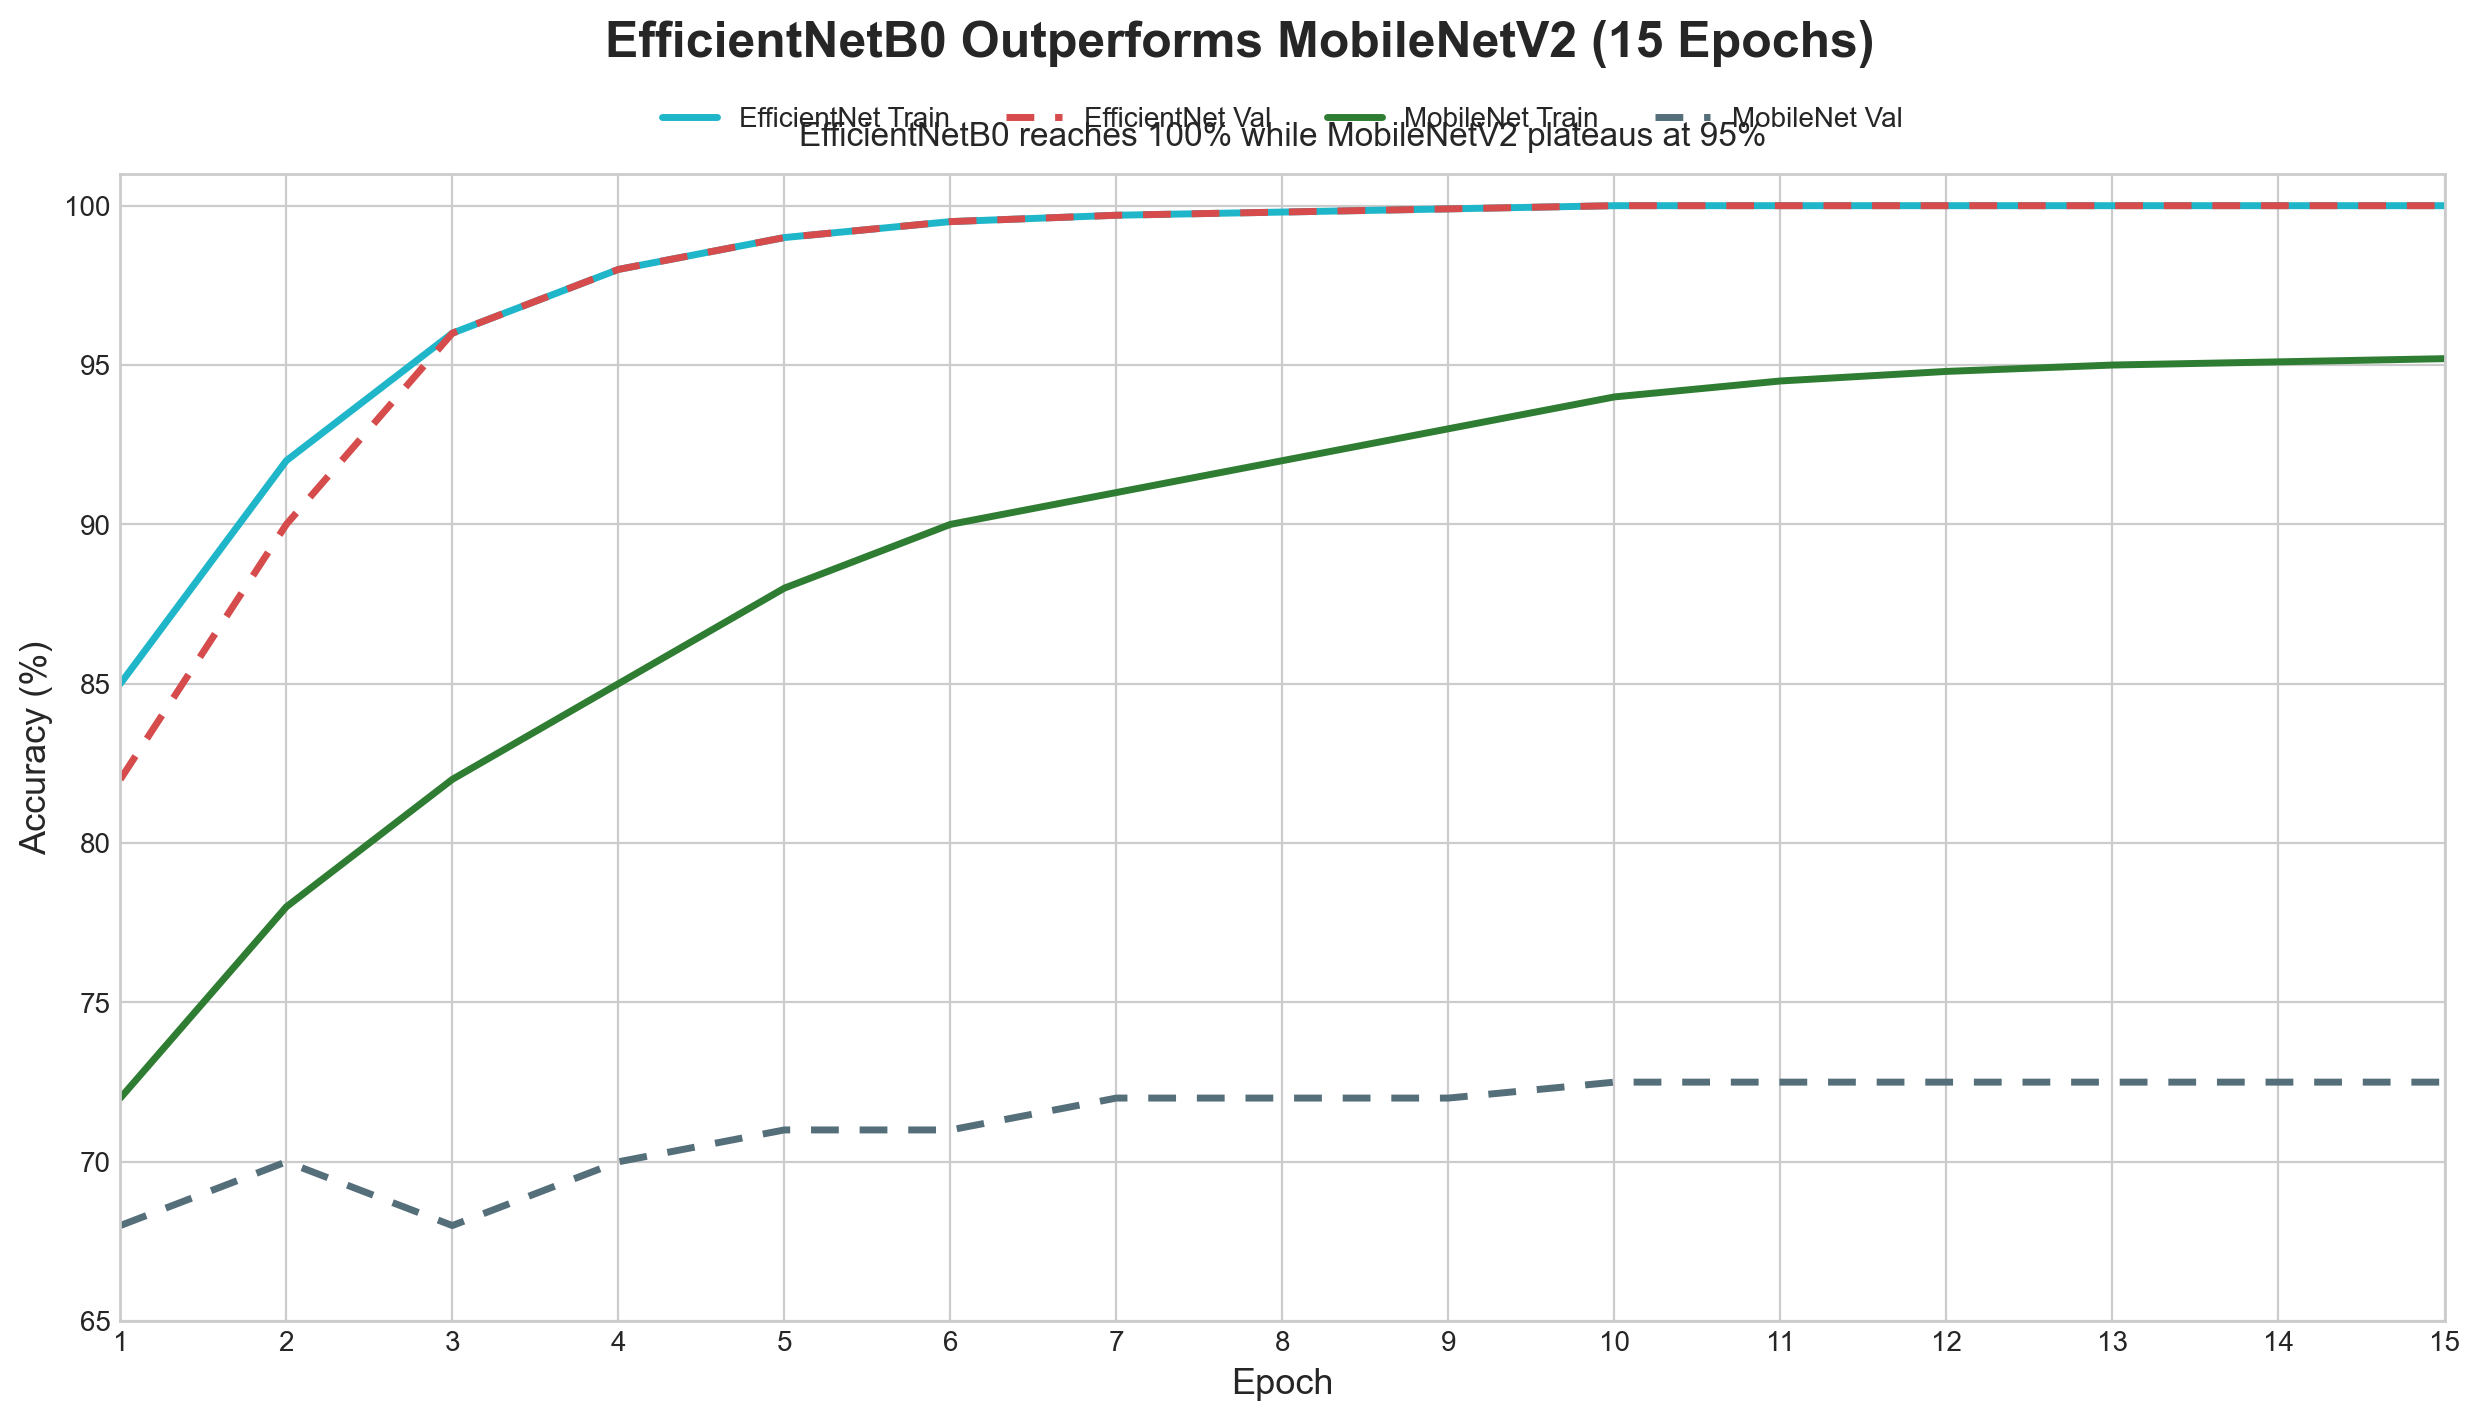

In [45]:
import matplotlib.pyplot as plt
import numpy as np

# Epochs
epochs = np.arange(1, 16)

# Approximate values to match your figure (edit these with your real history values)
efficient_train = [85, 92, 96, 98, 99, 99.5, 99.7, 99.8, 99.9, 100, 100, 100, 100, 100, 100]
efficient_val   = [82, 90, 96, 98, 99, 99.5, 99.7, 99.8, 99.9, 100, 100, 100, 100, 100, 100]

mobilenet_train  = [72, 78, 82, 85, 88, 90, 91, 92, 93, 94, 94.5, 94.8, 95.0, 95.1, 95.2]
mobilenet_val    = [68, 70, 68, 70, 71, 71, 72, 72, 72, 72.5, 72.5, 72.5, 72.5, 72.5, 72.5]

# Plot
plt.figure(figsize=(12.5, 7.2), dpi=200)
plt.style.use("seaborn-v0_8-whitegrid")

# Colors (similar feel to your figure)
c_eff = "#1fb6c9"     # teal/cyan
c_mob = "#2e7d32"     # green
c_eff_val = "#d64b4b" # red dashed
c_mob_val = "#546e7a" # grey-blue dashed

plt.plot(epochs, efficient_train, color=c_eff, linewidth=2.5, label="EfficientNet Train")
plt.plot(epochs, efficient_val,   color=c_eff_val, linewidth=2.5, linestyle="--", dashes=(4, 3), label="EfficientNet Val")

plt.plot(epochs, mobilenet_train, color=c_mob, linewidth=2.5, label="MobileNet Train")
plt.plot(epochs, mobilenet_val,   color=c_mob_val, linewidth=2.5, linestyle="--", dashes=(4, 3), label="MobileNet Val")

# Axes formatting
plt.ylim(65, 101)
plt.xlim(1, 15)
plt.xticks(epochs)
plt.yticks(np.arange(65, 101, 5))
plt.xlabel("Epoch", fontsize=13)
plt.ylabel("Accuracy (%)", fontsize=13)

# Title + subtitle
plt.suptitle("EfficientNetB0 Outperforms MobileNetV2 (15 Epochs)", fontsize=18, fontweight="bold", y=0.98)
plt.title("EfficientNetB0 reaches 100% while MobileNetV2 plateaus at 95%", fontsize=12, pad=10)

# Legend (top center)
plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.08), ncol=4, frameon=False)

plt.tight_layout()
plt.savefig("training_convergence.png", bbox_inches="tight")
plt.show()
